In [1]:
import sys
sys.path.insert(0,'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages')
sys.path.insert(0,'../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sxs
import qnmfits
sys.path.insert(0,'../qnmfits')
import read_waveforms

As an example, load SXS waveform to pull apart a time array and (l,m) mode into arrays to demonstrate how one would use generic waveforms.

In [3]:
h = sxs.load('SXS:BBH:0305/Lev/rhOverM', extrapolation_order=2)
h = read_waveforms.sxs_to_scri_WM(h)
h.t -= h.max_norm_time()

metadata = sxs.load('SXS:BBH:0305/Lev/metadata.json')
Mf = metadata.remnant_mass
chif = np.linalg.norm(metadata.remnant_dimensionless_spin)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json


Create a `WaveformModes` object containing only (2,2) mode

In [4]:
times = h.t
h_22 = h.data[:,4]
print(type(h_22))

h_wm_22 = read_waveforms.to_WaveformModes(times, {(2,2):h_22}, ell_max=2)

<class 'numpy.ndarray'>


In [5]:
qnms = [(2,2,n,1) for n in range(7+1)]
t0_array = np.linspace(0, 50, 120)
frequencies = [qnmfits.qnm_from_tuple(mode, chif, Mf)[0] for mode in qnms]

amp_list = np.zeros((len(t0_array),len(qnms)), complex).T
for t, t0 in enumerate(t0_array):
    h_shifted_22 = h_wm_22.copy()[np.argmin(abs(h_wm_22.t - t0)):np.argmin(abs(h_wm_22.t - 90))+1,:]
    h_shifted_22.t = h_shifted_22.t - h_shifted_22.t[0]
        
    best_fit_22 = qnmfits.fit(
    h_shifted_22,
    chif,
    Mf,
    qnms,
    spherical_modes=None,
    t_0=t0
)
    amp_list[:,t] = list(best_fit_22.values())

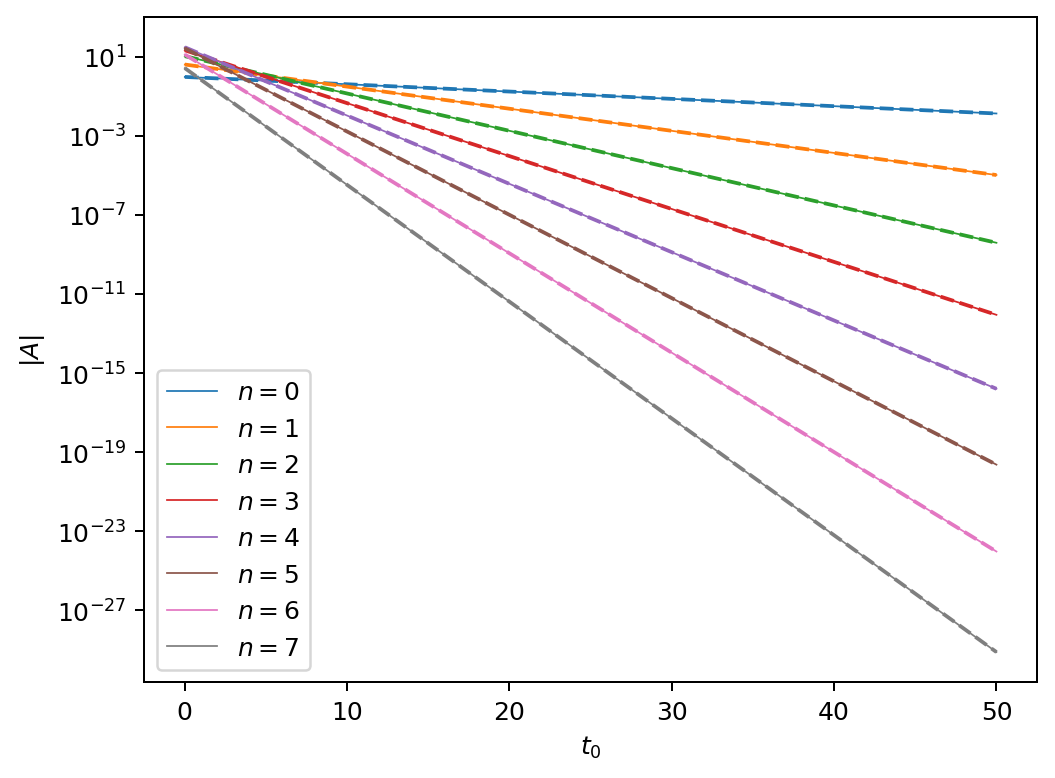

In [6]:
fig, ax = plt.subplots(dpi=180)
ax.set_yscale('log')

for n in range(len(qnms)):
    amp_decay = abs(amp_list[n][0]) * np.exp( np.imag(frequencies[n])* t0_array)

    ax.plot(t0_array, amp_decay, label=f'$n={n}$',lw=.7)

    # The expected amplitude decay from the QNM frequency
    tau = -1/np.imag(frequencies[n])
    expected_amp = abs(amp_list[n][0])*np.exp(-t0_array/tau)

    ax.plot(t0_array, expected_amp, c=f'C{n}', ls='--')

ax.set_xlabel('$t_0$')
ax.set_ylabel('$|A|$')

_ = ax.legend()